In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from env import user, password, host
import os
from acquire import wrangle_store_data
import warnings
warnings.filterwarnings("ignore")

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [2]:
# The following are functions contained in the accompanying acquire.py file

# def get_db_url(database):
#     return f'mysql+pymysql://{user}:{password}@{host}/{database}'

# def get_store_data():
#     '''
#     Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
#     '''
#     query = '''
#     SELECT *
#     FROM items
#     JOIN sales USING(item_id)
#     JOIN stores USING(store_id) 
#     '''
#     
#     df = pd.read_sql(query, get_db_url('tsa_item_demand'))
#     
#     df.to_csv('tsa_item_demand.csv', index=False)
#     
#     return df
# 
# def wrangle_store_data():
#     filename = 'tsa_store_data.csv'
#     
#     if os.path.isfile(filename):
#         df = pd.read_csv(filename)
#     else:
#         df = get_store_data()
#         
#     return df

In [3]:
df = wrangle_store_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   item_upc14     913000 non-null  int64  
 3   item_upc12     913000 non-null  int64  
 4   item_brand     913000 non-null  object 
 5   item_name      913000 non-null  object 
 6   item_price     913000 non-null  float64
 7   sale_id        913000 non-null  int64  
 8   sale_date      913000 non-null  object 
 9   sale_amount    913000 non-null  int64  
 10  store_address  913000 non-null  object 
 11  store_zipcode  913000 non-null  int64  
 12  store_city     913000 non-null  object 
 13  store_state    913000 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 97.5+ MB


In [5]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


# 1.Convert date column to datetime format.
Set Datetime Index

In [6]:
# Reassign the sale_date column to be a datetime type
df.sale_date = pd.to_datetime(df.sale_date)
df.sale_date

0        2013-01-01
1        2013-01-02
2        2013-01-03
3        2013-01-04
4        2013-01-05
            ...    
912995   2017-12-27
912996   2017-12-28
912997   2017-12-29
912998   2017-12-30
912999   2017-12-31
Name: sale_date, Length: 913000, dtype: datetime64[ns]

In [7]:
df.shape[0], df.sale_id.nunique()

(913000, 913000)

In [8]:
def convert_datetime():
    df.sale_date = pd.to_datetime(df.sale_date)

In [9]:
#convert_datetime()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   store_id       913000 non-null  int64         
 1   item_id        913000 non-null  int64         
 2   item_upc14     913000 non-null  int64         
 3   item_upc12     913000 non-null  int64         
 4   item_brand     913000 non-null  object        
 5   item_name      913000 non-null  object        
 6   item_price     913000 non-null  float64       
 7   sale_id        913000 non-null  int64         
 8   sale_date      913000 non-null  datetime64[ns]
 9   sale_amount    913000 non-null  int64         
 10  store_address  913000 non-null  object        
 11  store_zipcode  913000 non-null  int64         
 12  store_city     913000 non-null  object        
 13  store_state    913000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(7), object(5

In [11]:
df.sale_date

0        2013-01-01
1        2013-01-02
2        2013-01-03
3        2013-01-04
4        2013-01-05
            ...    
912995   2017-12-27
912996   2017-12-28
912997   2017-12-29
912998   2017-12-30
912999   2017-12-31
Name: sale_date, Length: 913000, dtype: datetime64[ns]

# 2. Plot the distribution of sale_amount and item_price.

Plot Target Variable Over Time
Generate a quick plot of our target variable over time, the variable we wish to forecast or predict. We will first aggregate the sale_amount by sale_date using sum(), i.e. group by sale_date and sum the sale_amount. We will then do a quick plot of this aggregated data.

In [12]:
by_date = df.groupby(['sale_date']).sale_amount.sum().reset_index()
by_date.head()

,sale_date,sale_amount
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


<AxesSubplot:xlabel='sale_date'>

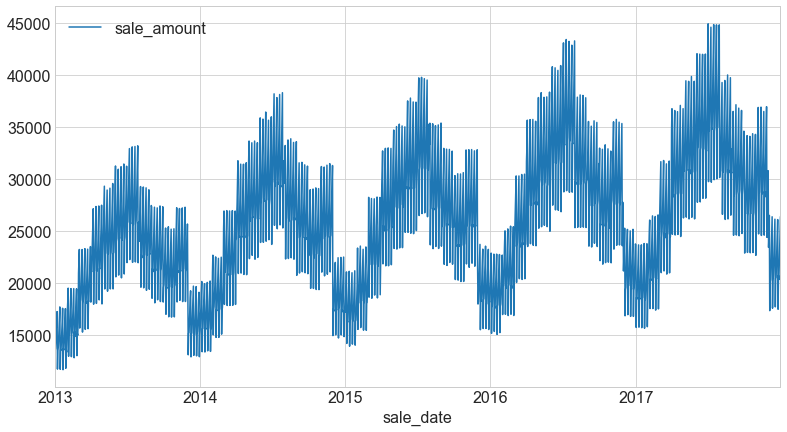

In [13]:
by_date.plot(x='sale_date', y='sale_amount')

In [14]:
def by_date():
    by_date = df.groupby(['sale_date']).sale_amount.sum().reset_index()
    by_date.plot(x='sale_date', y='sale_amount')

In [15]:
#by_date()

# 3. Set the index to be the datetime variable.

In [16]:
# Set the index as that date and then sort index (by the date)
df = df.set_index("sale_date").sort_index()

In [17]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX


# 4. Add a 'month' and 'day of week' column to your dataframe.

In [18]:
df.dtypes

store_id           int64
item_id            int64
item_upc14         int64
item_upc12         int64
item_brand        object
item_name         object
item_price       float64
sale_id            int64
sale_amount        int64
store_address     object
store_zipcode      int64
store_city        object
store_state       object
dtype: object

In [19]:
df['month'] = df.index.month

df['day_of_week'] = df.index.day_name

df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,1,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,1,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,1,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,1,<bound method _inherit_from_data.<locals>.meth...


In [20]:
df['month'] = df.index.strftime('%B')
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...


# 5. Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.

In [21]:
df['sales_total'] =  df['sale_amount'] * df['item_price']

In [22]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,January,<bound method _inherit_from_data.<locals>.meth...,25.16


# 6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

Did it.

In [23]:
def prep_store_data(df):
    # Reassign the sale_date column to be a datetime type
    df.sale_date = pd.to_datetime(df.sale_date)

    # Sort rows by the date and then set the index as that date
    df = df.set_index("sale_date").sort_index()
    return df